best check point with acc 0.99: https://drive.google.com/drive/folders/1OJ4DSoqO7YJPhQU2zI8pyTr-YUiCk46N?usp=sharing

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Download dataset from git hub
%cd /content/drive/MyDrive/CIFAR10/
!rm -rf '/content/drive/MyDrive/CIFAR10/CIFAR-10-images'
!git clone https://github.com/YoongiKim/CIFAR-10-images.git '/content/drive/MyDrive/CIFAR10/CIFAR-10-images'


/content/drive/MyDrive/CIFAR10
Cloning into '/content/drive/MyDrive/CIFAR10/CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 13.82 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Updating files: 100% (60001/60001), done.


# Install requirements

In [ ]:
!pip install easydict
!pip install loguru
!pip install torch==2.1.2 torchvision==0.16.2 --index-url https://download.pytorch.org/whl/cu118
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.2 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 711.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [ ]:
!pip install seaborn

# Import lib

In [ ]:
import os
from pathlib import Path

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW, SGD, Adam
from torch.optim.lr_scheduler import OneCycleLR

from torchvision import transforms

import cv2
import numpy as np
import albumentations as A
import PIL
from PIL import Image

In [ ]:
from tqdm import tqdm
from loguru import logger

# EDA

Check the data distribution and visualize the data to get a better understanding of the data.
- Image with smal size 32x32
- 10 classes and each class has the same number of images on both train and test set => balanced dataset
- For simplicity, we will use the train set to train the model and the test set to evaluate the model.

### Train set

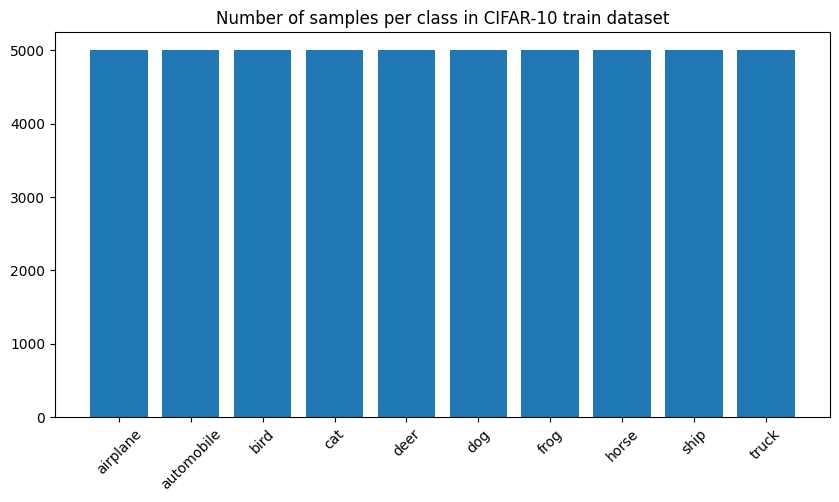

In [ ]:
# get number samples of each class
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_samples = {}

all_files = list(Path('./CIFAR-10-images/train').rglob('*.jpg'))

#count number of labels
num_samples = {label: 0 for label in labels}
for file in all_files:
    label = file.parts[-2]
    num_samples[label] += 1

#draw bar chart in vertical
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title('Number of samples per class in CIFAR-10 train dataset')
plt.bar(num_samples.keys(), num_samples.values())
plt.xticks(rotation=45)
plt.show()


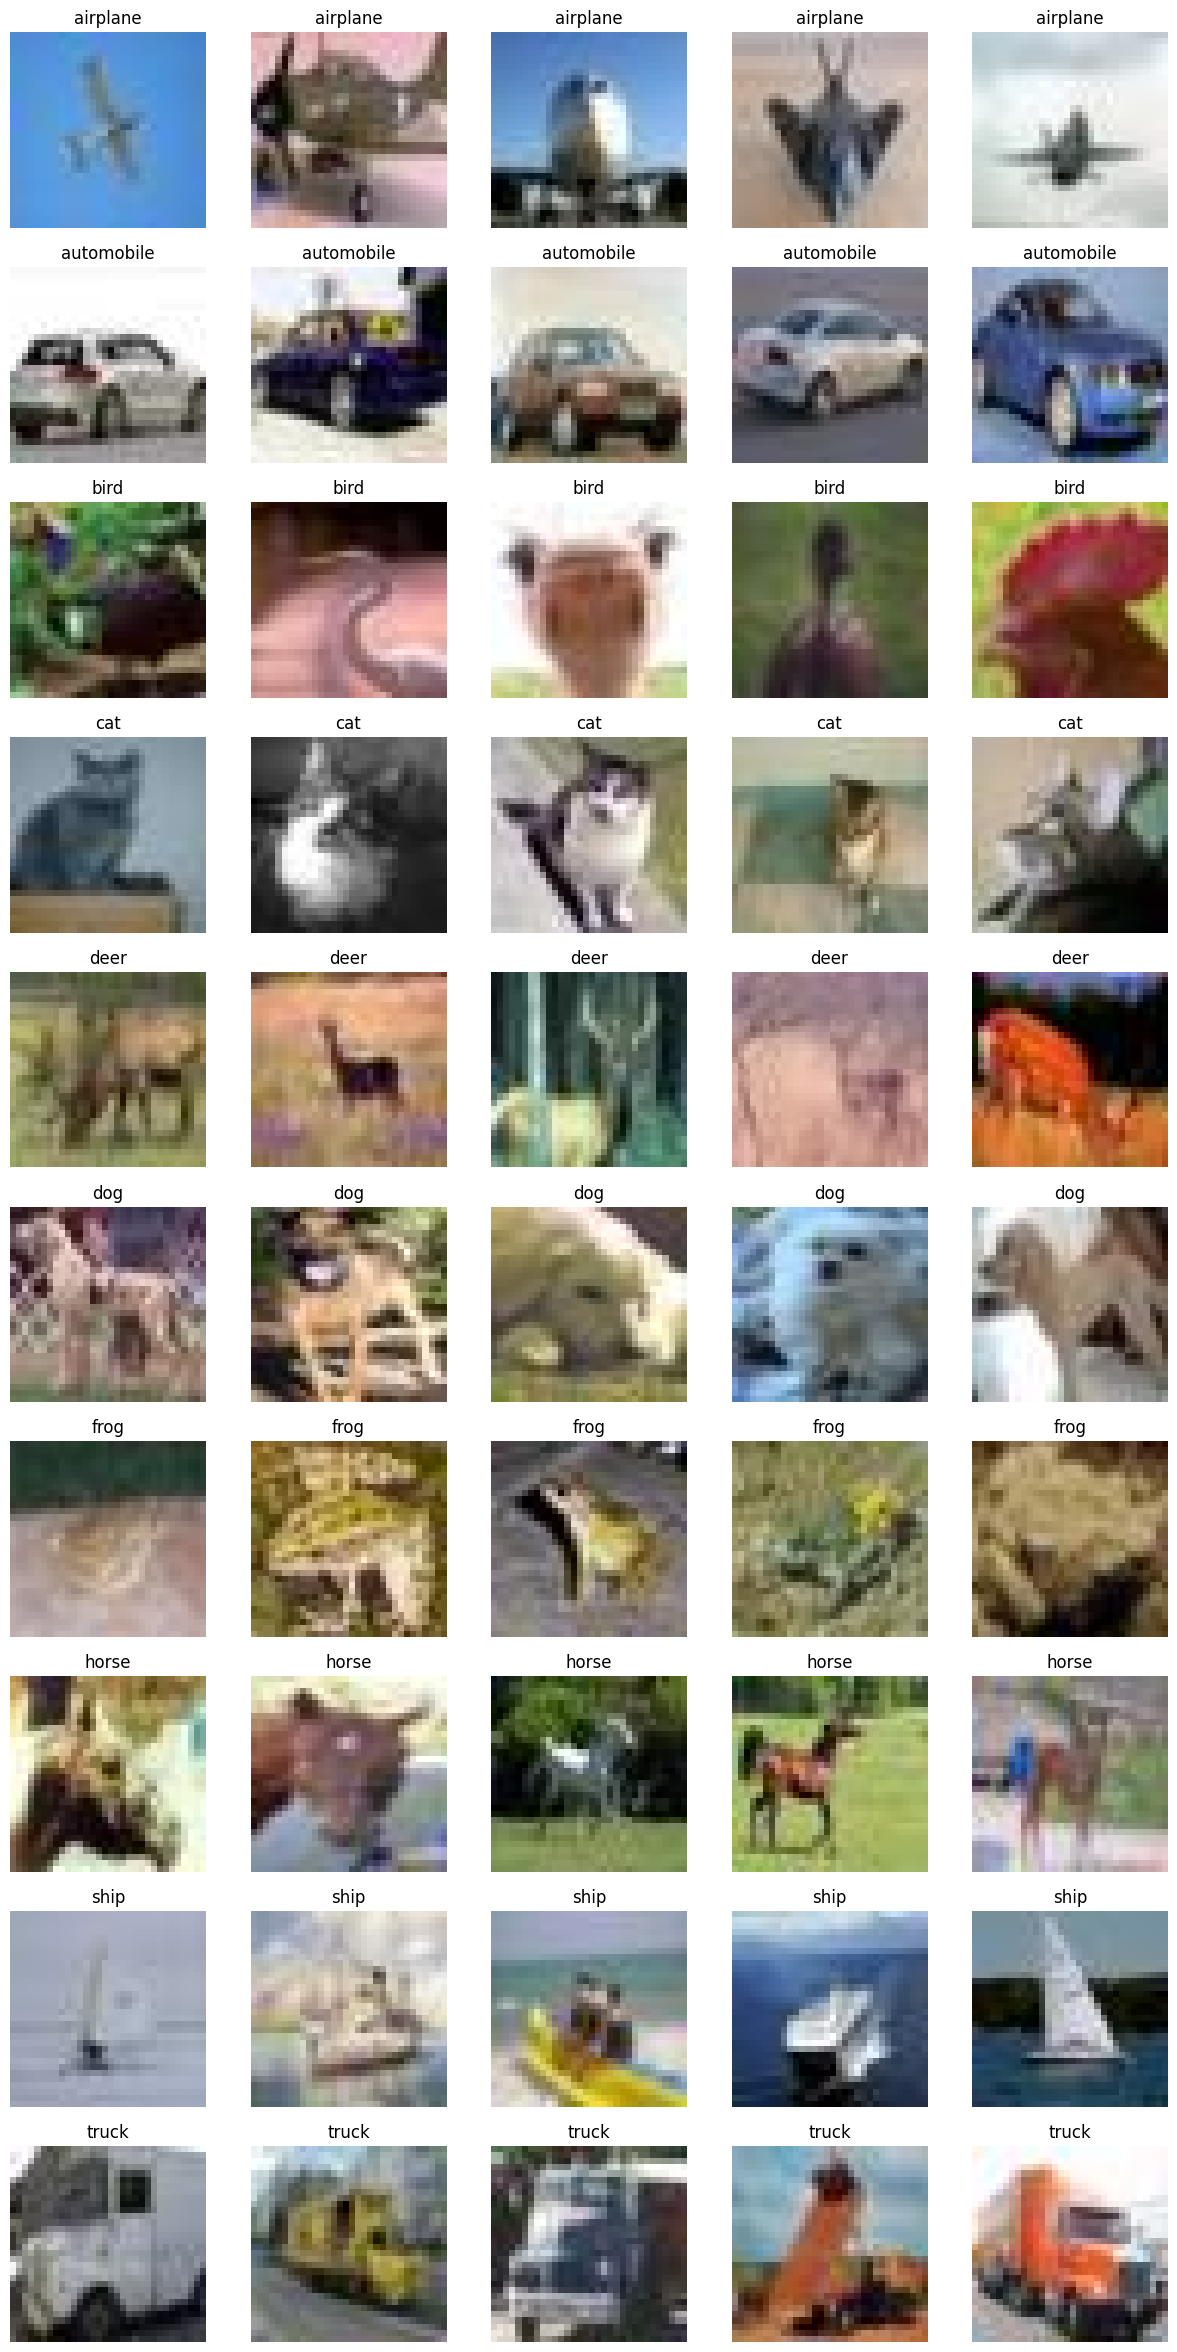

In [ ]:
# Draw some examples of each class
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 5, figsize=(15, 30))
for label_idx, label in enumerate(labels):
    label_files = list(Path(f'./CIFAR-10-images/train/{label}').rglob('*.jpg'))
    for i in range(5):
        img = cv2.imread(str(random.choice(label_files)))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[label_idx, i].imshow(img)
        axes[label_idx, i].axis('off')
        axes[label_idx, i].set_title(label)

### Test set

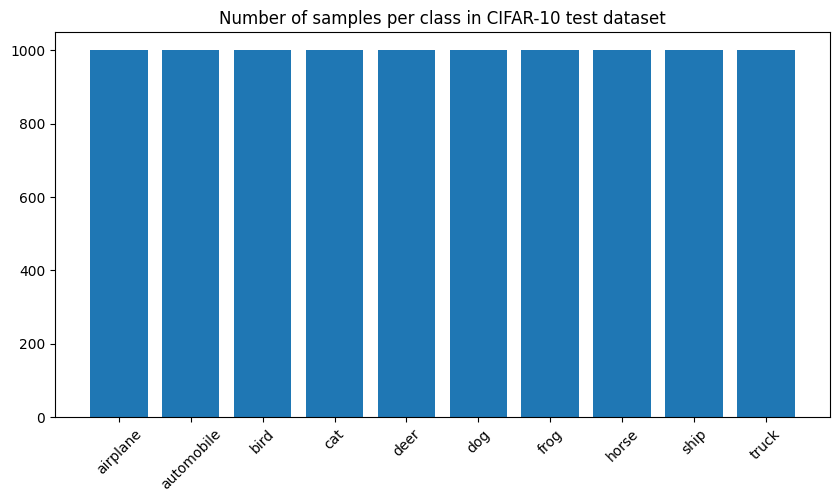

In [ ]:
# do the same for test dataset
num_samples_test = {label: 0 for label in labels}
all_files_test = list(Path('./CIFAR-10-images/test').rglob('*.jpg'))

for file in all_files_test:
    label = file.parts[-2]
    num_samples_test[label] += 1


plt.figure(figsize=(10, 5))
plt.title('Number of samples per class in CIFAR-10 test dataset')
plt.bar(num_samples_test.keys(), num_samples_test.values())
plt.xticks(rotation=45)
plt.show()


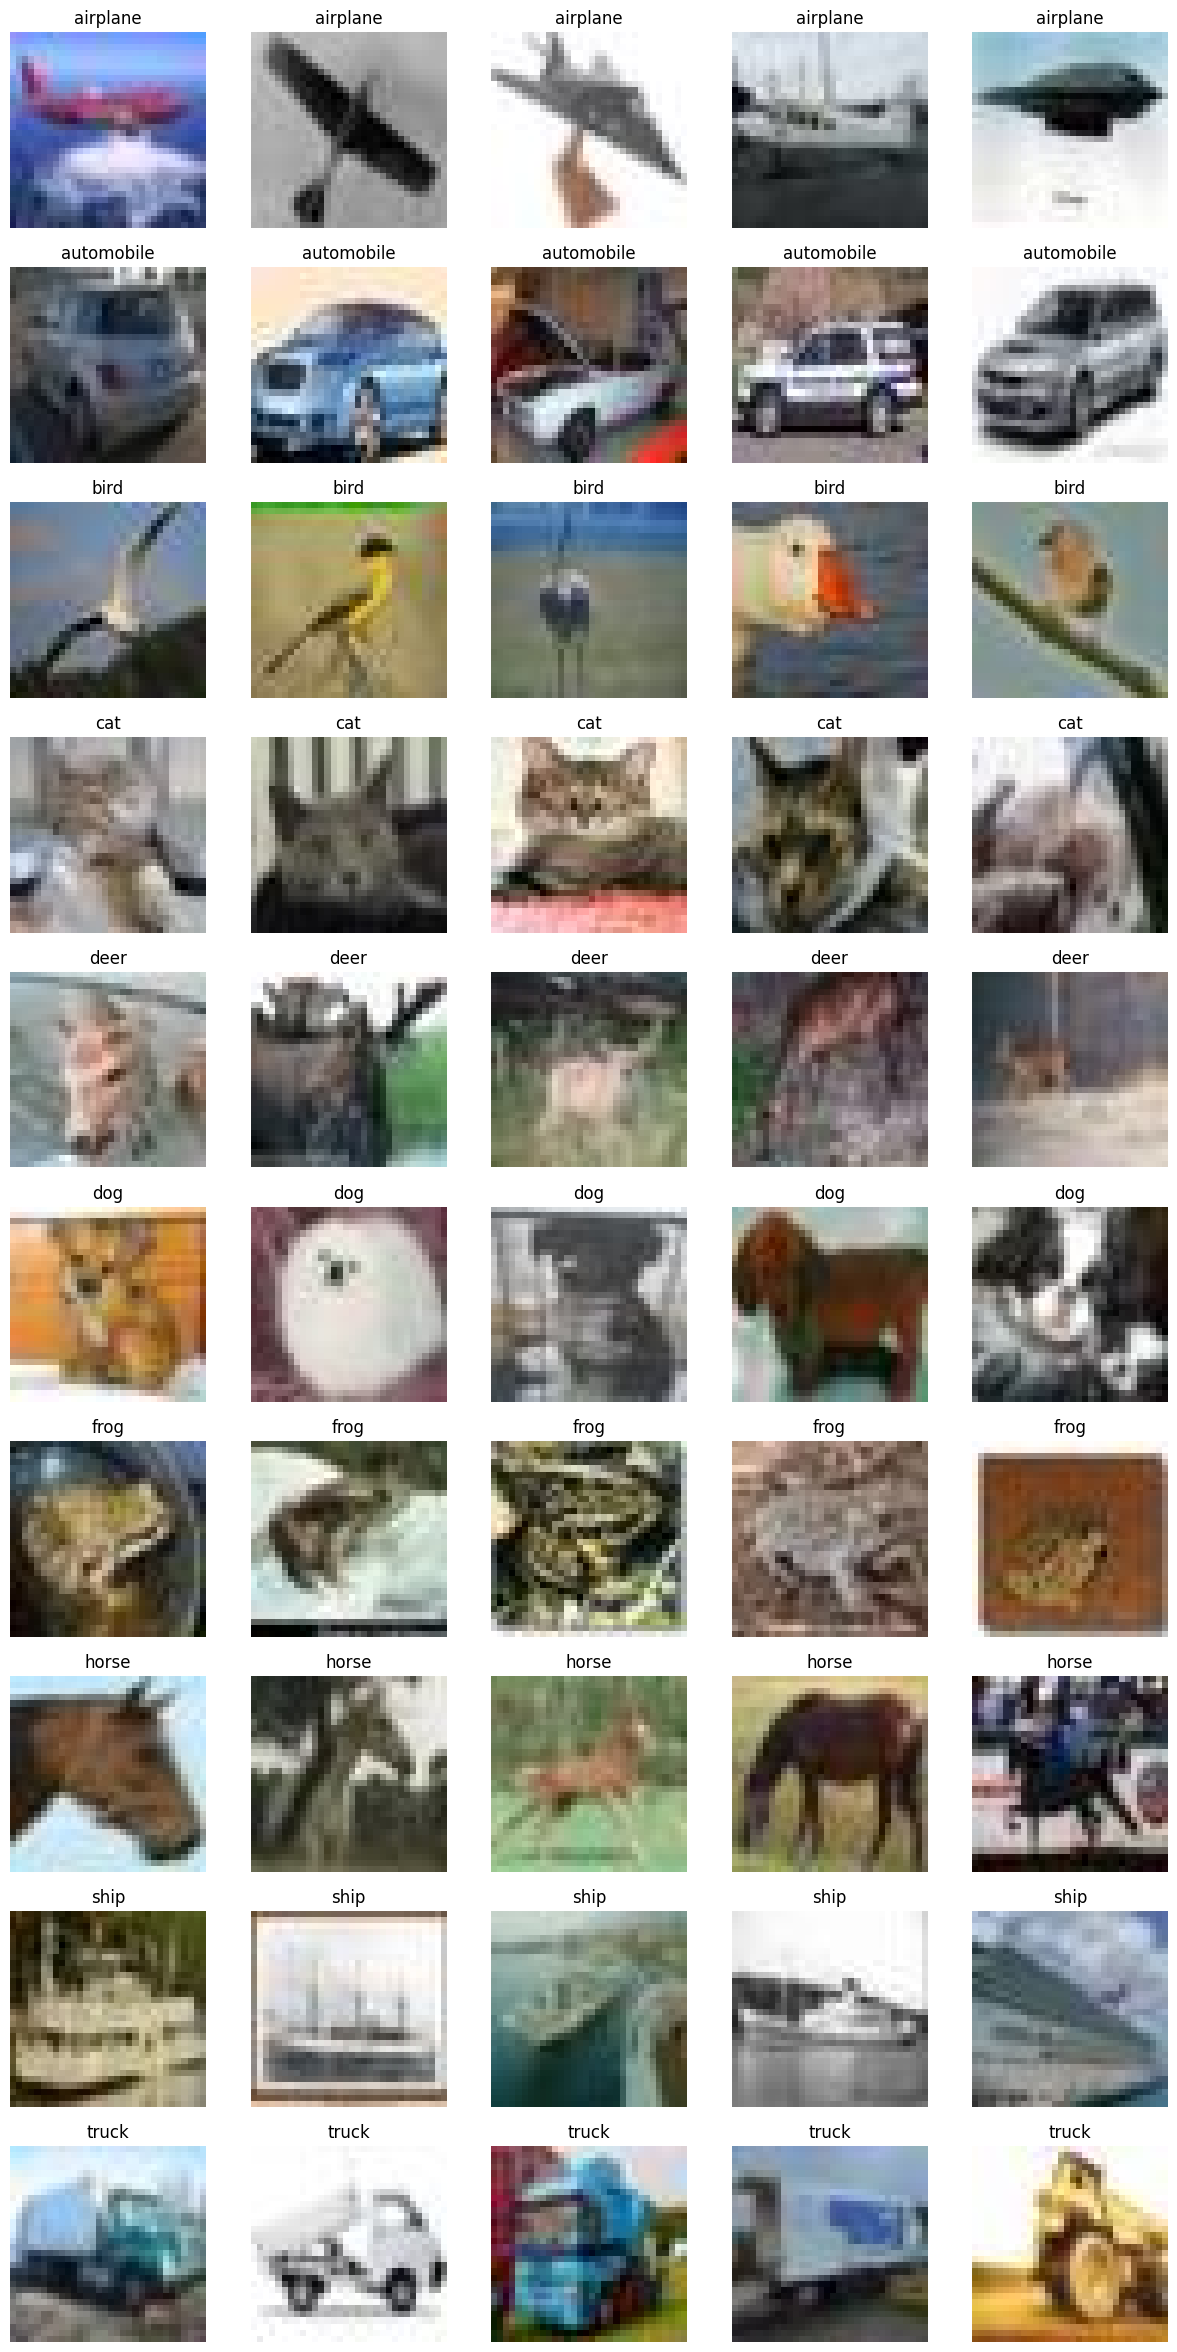

In [ ]:
# draw some examples of each class in test dataset
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
for label_idx, label in enumerate(labels):
    label_files = list(Path(f'./CIFAR-10-images/test/{label}').rglob('*.jpg'))
    for i in range(5):
        img = cv2.imread(str(random.choice(label_files)))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[label_idx, i].imshow(img)
        axes[label_idx, i].axis('off')
        axes[label_idx, i].set_title(label)


# Dataset

Using pytorch dataset to load the data


The preprocess step:
- Resize the image to 32x32 => make sure all the images have the same size
- Do data augmentation if the set is train set => make the model more robust to the unseen data
- Normalize the image => make the model converge faster and more stable
- Convert the image to tensor => for training with pytorch

In [ ]:
class CIFAR10Dataset(Dataset):
    """
    Dataset class for CIFAR-10 dataset
    """
    def __init__(self, config, augmentations=None, split='train'):
        self.config = config
        self.split = split
        self.image_dir = Path(config.image_dir) / f'{self.split}'
        self.image_list = list((self.image_dir).rglob("*.jpg"))
        self.augmentations = augmentations

        self.label_list = config.label_list # list of class names
        self.label_dict = {k:i for i, k in enumerate(self.label_list)} # dict of class names and their corresponding index

        self.img_size = config.img_size
        self.mean = config.normalize.mean
        self.std = config.normalize.std

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = str(self.image_list[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_path.split('/')[-2]
        label = self.label_dict[label]

        if self.augmentations:
            image = self.augmentations(image=image)['image'] # augmentation cv2 image with albumentations library

        image = self.normalize_image(image)

        image = torch.tensor(image).float()
        label = torch.tensor(label).long()

        return image, label

    def normalize_image(self, image):
        """
        Normalize image to range 0-1 and apply mean and std normalization
        """
        image = image.astype(np.float32)
        image = image / 255.0
        image = (image - self.mean) / self.std
        image = np.transpose(image, (2, 0, 1))
        return image




## Dataloader

Build the dataloader to load the data to the model with predefined batch size and number of workers.

In [ ]:
class CIFARDataloader:
    """
    CIFAR-10 dataloader class
    """
    def __init__(self, config, augmentations):
        self.config = config
        self.augmentations = augmentations

        self.train_loader = self.get_train_dataloader()
        self.valid_loader = self.get_valid_dataloader()
        self.test_loader = self.get_test_dataloader()

    def _build_dataloader(self, split="train"):
        shuffle = True if split == 'train' else False
        augmentations = self.augmentations if split == 'train' else None
        dataset =  CIFAR10Dataset(self.config, augmentations, split=split)
        return DataLoader(dataset, batch_size=self.config.batch_size, shuffle=shuffle, num_workers=self.config.num_workers, collate_fn=self.collate_fn)

    def get_train_dataloader(self):
        return self._build_dataloader(split="train")

    def get_valid_dataloader(self):
        # split  = test cause we don't have validation set in CIFAR-10
        return self._build_dataloader(split="test")

    def get_test_dataloader(self):
        return self._build_dataloader(split="test")

    def collate_fn(self, batch):
        """
        Batch collate function
        """
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.stack(labels)
        return images, labels




## Data augmentations

Using albumentations library for data augmentation

In [ ]:
augmentations_basic = A.Compose(
    [
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1, p=0.2),
        A.RGBShift(p=0.2),
        A.Rotate(limit=10, p=0.3),
        A.HorizontalFlip(p=0.5),
        A.PixelDropout(p=0.5, dropout_prob=0.02),
        A.Affine(translate_percent=(-0.15, 0.15), scale=(0.75, 0.95), shear=(-20, 20) ,p=0.5),
        A.CoarseDropout(max_holes=5, max_height=4, max_width=4, min_holes=1, min_height=4, min_width=4, p=0.3),
        A.RandomResizedCrop(height=32, width=32, scale=(0.7, 1.0), ratio=(0.75, 1.3333333333333333), p=0.3),
    ]
)

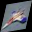

In [ ]:
# visualize augmentation
image = cv2.imread('./CIFAR-10-images/train/airplane/0001.jpg')
image = augmentations_basic(image=image)['image']
PIL.Image.fromarray(image)

# Modelling

### experiment 1

This is optional, you can skip this step if you want to train the model with the default setting.

In [ ]:
class CIFARClassifier(nn.Module):

    def __init__(self, num_cls=10):
        super().__init__()
        self.num_cls = num_cls

        self.stemp = nn.Conv2d(3, 64, 3, 1, 1)

        # 1st block
        self.conv_block1 = self.conv_block(64, 64, 3, 1, 1)

        # 2nd block
        self.conv_block2 = self.conv_block(64, 128, 3, 2, 1)

        # 3rd block
        self.conv_block3 = self.conv_block(128, 256, 3, 2, 1)

        # 4rd block
        self.conv_block4 = self.conv_block(256, 512, 3, 2, 1)

        self.conv_block5 = self.conv_block(512, 512, 3, 2, 1)

        # pool
        self.pool = nn.MaxPool2d(2)

        # classifier
        self.fc1 = nn.Linear(512, 256)
        self.act = nn.ReLU()
        self.drop_out = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_cls)

    def forward(self, x):
        x = self.stemp(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x= self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop_out(x)
        x = self.fc2(x)

        return x

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        return layer

### experiment 2

Build the model with the architecture inspired by the ResNet model with residual block.

In [ ]:
class CIFARClassifierResnet9(nn.Module):

    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        self.conv1 = self.conv_block(in_channels, 64)
        self.conv2 = self.conv_block(64, 128, pool=True)

        self.res1 = nn.Sequential(self.conv_block(128, 128),
                                  self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, pool=True)
        self.conv4 = self.conv_block(256, 512, pool=True)

        self.res2 = nn.Sequential(self.conv_block(512, 512),
                                  self.conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def conv_block(self, in_channels, out_channels, pool=False):
        """
        Basic convolutional block for ResNet
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

# CallBacks

Implement the callback to save the best model during the training process.

simple EarlyStopping callback to stop the training process if the model does not improve after a certain number of epochs.

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, valid_loss):
        """
        Check if the model should be early stopped
        """
        if (valid_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

# Trainer

Build the trainer to train the model with the train set and evaluate the model with the test set.

In [ ]:
class Trainer:

    def __init__(self, config, augmentations=augmentations_basic):
        """
        Trainer class for CIFAR-10 dataset
        """
        self.config = config
        self.augmmentations = augmentations

        self.data_loader = CIFARDataloader(config.dataset, self.augmmentations)
        self.model = CIFARClassifierResnet9().to(self.config.device)
        self.optimizer, self.scheduler = self.build_optimizer()
        self.loss = nn.CrossEntropyLoss().to(self.config.device)

        self.early_stopping = EarlyStopping()


    def train(self):
        n_epoch = self.config.trainer.n_epoch

        for epoch in range(n_epoch):
            self.model.train()
            train_acc = []
            train_loss = []

            # train 1 epoch
            batch_train_loop = tqdm(self.data_loader.train_loader, desc=f'Epoch {epoch}') # tqdm for progress bar
            for batch in batch_train_loop:
                img, label = batch

                img = img.to(self.config.device)
                label = label.to(self.config.device)

                pred = self.model(img) # forward pass
                loss = self.loss(pred, label) # calculate loss

                self.optimizer.zero_grad() # zero gradients
                loss.backward() # backpropagation
                self.optimizer.step() # update weights
                self.scheduler.step() # update learning rate

                pred = torch.argmax(pred, dim=1)
                acc = torch.mean((pred == label).float()) # calculate accuracy on step
                train_acc.append(acc) # append accuracy to accuracy epoch list
                train_loss.append(loss.item())

                batch_train_loop.set_postfix(loss=loss.item(), accuracy=acc.item()) # print loss and accuracy on each step

            # evaluate after 1 epoch
            with torch.no_grad():
                valid_acc = []
                valid_loss = []
                self.model.eval()

                batch_valid_loop = tqdm(self.data_loader.valid_loader, desc=f'Valid Epoch {epoch}') # tqdm for progress bar
                for batch in batch_valid_loop:
                    img, label = batch
                    img = img.to(self.config.device)
                    label = label.to(self.config.device)

                    pred = self.model(img)
                    loss_valid = self.loss(pred, label)

                    pred = torch.argmax(pred, dim=1)
                    acc = torch.mean((pred == label).float())

                    valid_acc.append(acc)
                    valid_loss.append(loss_valid.item())
                    batch_valid_loop.set_postfix(accuracy=acc.item()) # print accuracy on each step

            train_acc_epoch = torch.mean(torch.tensor(train_acc))
            valid_acc_epoch = torch.mean(torch.tensor(valid_acc))

            train_loss = torch.mean(torch.tensor(train_loss))
            valid_loss = torch.mean(torch.tensor(valid_loss))

            logger.info(f'Epoch {epoch}  Train Accuracy: {train_acc_epoch.item()} - Valid Accuracy: {valid_acc_epoch.item()}') # print accuracy on each epoch

            if not os.path.exists(self.config.trainer.save_dir):
                os.makedirs(self.config.trainer.save_dir, exist_ok=True)

            torch.save(self.model.state_dict(), f'{self.config.trainer.save_dir}/model_{epoch}_val_acc_{valid_acc_epoch.item()}.pth')
            if self.early_stopping(train_loss, valid_loss):
                logger.info('Early Stopping')
                break

        self.test()


    def test(self, model_path=None):
        """
        Plot confusion matrix
        """
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt

        if model_path:
            self.model.load_state_dict(torch.load(model_path))
            self.model.to(self.config.device)

        y_true = []
        y_pred = []

        with torch.no_grad():
            self.model.eval()
            for batch in self.data_loader.test_loader:
                img, label = batch
                img = img.to(self.config.device)
                label = label.to(self.config.device)

                pred = self.model(img)
                pred = torch.argmax(pred, dim=1)

                y_true.extend(label.cpu().numpy())
                y_pred.extend(pred.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.config.dataset.label_list, yticklabels=self.config.dataset.label_list)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()




    def build_optimizer(self):
        """
        Build optimizer and scheduler
        """
        lr = self.config.trainer.lr
        n_epoch = self.config.trainer.n_epoch # number of epochs
        num_steps = len(self.data_loader.train_loader) * n_epoch # total number of steps

        optim = Adam(self.model.parameters(), lr=lr, weight_decay=self.config.trainer.weight_decay) # Adam optimizer
        sched = OneCycleLR(optim, lr, num_steps) # One Cycle Policy learning rate scheduler

        return optim, sched


# Train

## Config

In [ ]:
from easydict import EasyDict as edict

In [ ]:
config = edict({
    'dataset': {
        'image_dir': './CIFAR-10-images',
        'label_list': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
        'img_size': (32, 32),
        'normalize': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'batch_size': 256,
        'num_workers': 8

    },
    'trainer': {
        'lr': 2e-3,
        'n_epoch': 5,
        'save_dir': './checkpoints',
        'weight_decay': 1e-4

    },
    'device': 'cpu'
})

In [ ]:
trainer = Trainer(config=config)

Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Valid Epoch 0: 100%|██████████| 40/40 [00:39<00:00,  1.02it/s, accuracy=0.25]
2024-04-14 01:43:43.680 | INFO     | __main__:train:77 - Epoch 0  Train Accuracy: 0.42490434646606445 - Valid Accuracy: 0.5503906011581421
Valid Epoch 1: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s, accuracy=0.875]
2024-04-14 01:51:35.187 | INFO     | __main__:train:77 - Epoch 1  Train Accuracy: 0.586340069770813 - Valid Accuracy: 0.674023449420929
Valid Epoch 2: 100%|██████████| 40/40 [00:38<00:00,  1.04it/s, accuracy=0.812]
2024-04-14 01:59:27.712 | INFO     | __main__:train:77 - Epoch 2  Train Accuracy: 0.6789621114730835 - Valid Accuracy: 0.724804699420929
Valid Epoch 3: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s, accuracy=

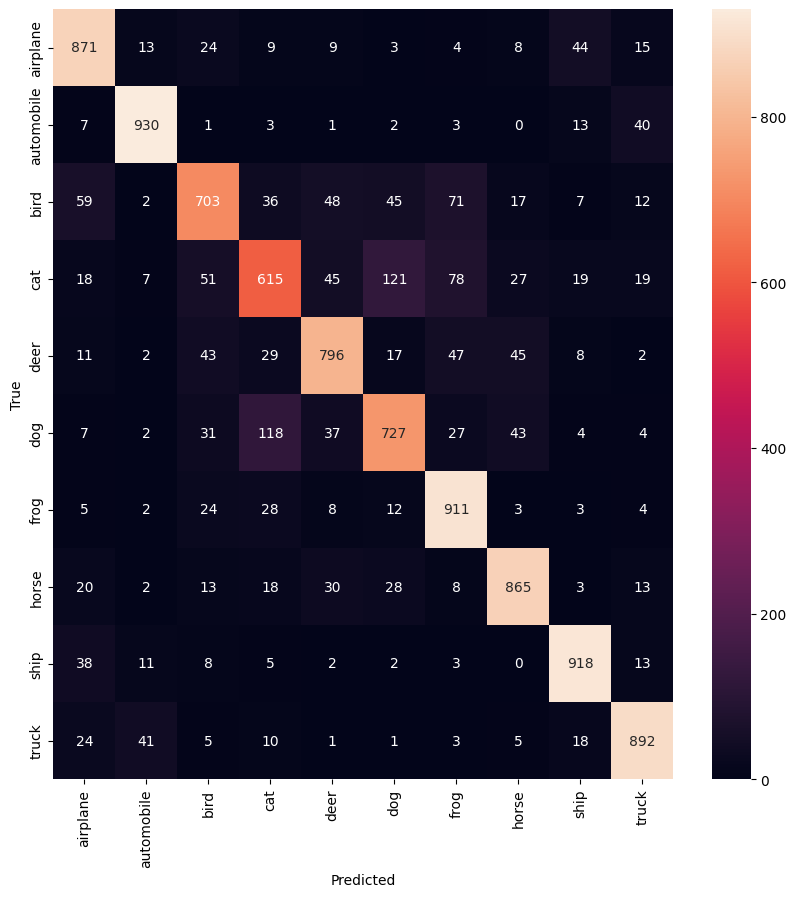

In [ ]:
trainer.train()

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


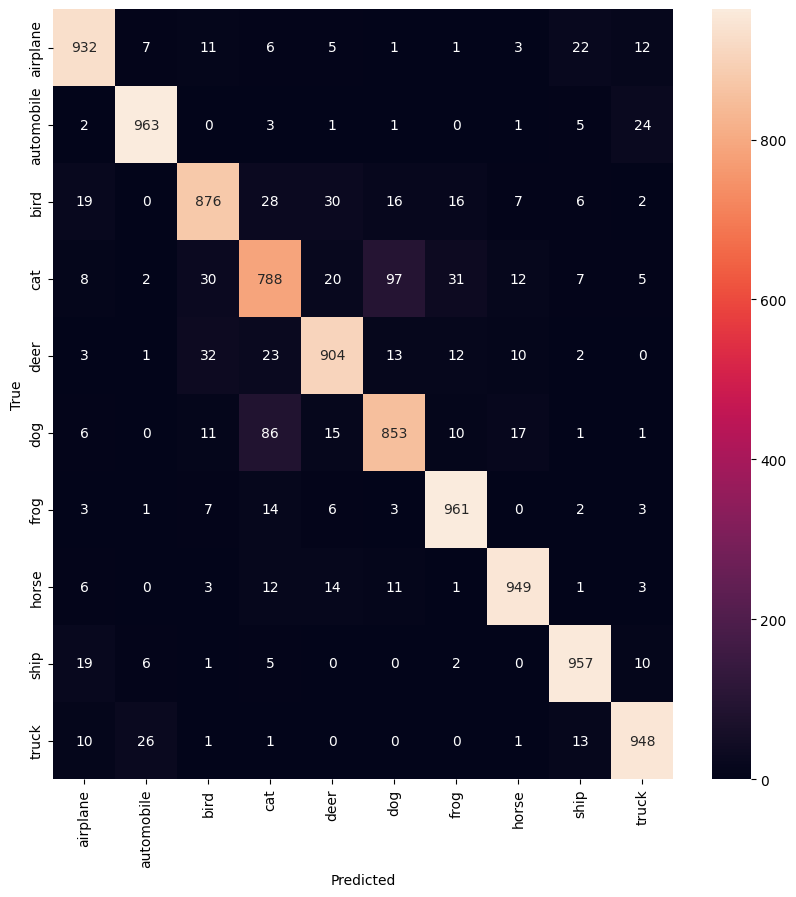

In [38]:
trainer.test('/content/model_99_acc_0.9136718511581421.pth')


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inference

## Process input inference

In [39]:
def infer_process(image):
    image = cv2.resize(image, (32, 32))
    image = image / 255.0
    image = (image - config.dataset.normalize.mean) / config.dataset.normalize.std
    image = np.transpose(image, (2, 0, 1))
    image = torch.tensor(image).float()
    image = image.unsqueeze(0)
    image = image.to(config.device)

    return image

## Load model

In [40]:
model = CIFARClassifierResnet9(3, 10)
state_dict = torch.load('/content/model_99_acc_0.9136718511581421.pth')
model.load_state_dict(state_dict, strict=True)
model = model.to(config.device)
model.eval()

CIFARClassifierResnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): 

## Run inference

Predicted label: airplane - Score: 0.9999955892562866


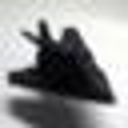

In [41]:
image = cv2.imread('./CIFAR-10-images/train/airplane/0000.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

inputs = infer_process(image)
outputs = model(inputs)


outputs = torch.softmax(outputs, dim=1)
scores = torch.max(outputs)

outputs = torch.argmax(outputs, dim=1)

predicted_label = config.dataset.label_list[outputs.item()]

print(f'Predicted label: {predicted_label} - Score: {scores}')
Image.fromarray(image).resize((128, 128))
